# <center> **Machine Learning for Social Data Science** </center>

## <center> **Problem Set 1** </center>

## <center> *Machine Learning the Identities of Labour’s Electorate: Random Forest and XGBoost on BES Wave 30 (1,500 words)* </center>

### **Introduction**

Electoral politics in the UK has undergone a profound change in recent decades, nowhere more evident than in the dramatic shift from Labour’s worst defeat in 2019 to securing a 174-seat majority on a vote share increase of just 1.7% (Bunting, 2025, p. 14). This conspicuous transformation raises an important question: which social identities underpinned Labour’s 2024 electoral coalition? Understanding the identity basis of this support matters not only for interpreting the results, but also for assessing whether traditional class alignments still structure vote choice or whether newer identity cleavages now play a more decisive role. Historically, scholarly accounts of British voting behaviour emphasised social class as the primary structuring force of party choice (Evans, 2000). Prosser et al. find that class-dominated elections from the mass enfranchisement of 1918 through the post-war period, before declining from the 1990s onwards (2024). In the wake of the decline of class-based voting, research has highlighted the growing salience of education, religion, ethnicity, gender, age, and other social identity factors (Johnston, Jones and Manley, 2018; Kolpinskaya and Fox, 2024; Simon, Jennings and Durrant, 2024; Bunting et al., 2025). Such identities may interact in complex and non-linear ways that traditional regression approaches may struggle to capture. 

To address this, this essay applies XGBoost and Random Forest models to the British Election Study (BES) (Fieldhouse et al., no date) data to predict Labour vote choice using identity variables. The structure of this essay is as follows: a data and methods section, followed by findings, and finally, a conclusion. 

### **Data and Methods**

This essay applies two ensemble learning techniques from Python, Random Forest and XGBoost, to model Labour vote choice. Both algorithms are based on decision trees, but they combine them in different ways to improve predictive performance. Random Forest constructs bagged decision trees by training multiple decision trees on bootstrapped samples and averaging their predictions, reducing variance and limiting overfitting through independent trees. In contrast, XGBoost builds boosted decision trees, sequentially adding new trees that focus on correcting the errors of previous, ‘weaker’ trees. By emphasising reduced bias, boosting iteratively improves predictive accuracy, often outperforming other approaches on complex datasets. Comparing these methods allows for a methodological assessment of whether sequential boosting or parallel bagging is more effective for predicting vote choice based on social identity factors. 

The data is drawn from Wave 28 of the BES internet panel. The BES is a nationally representative panel survey which is widely used in political behaviour research due to its extensive political attitude measures, detailed socio-demographic data collection, and its strong sampling strategy. Wave 28 is selected because it captures 30,342 respondents immediately prior to the 2024 General Election, providing timely measures of vote intention and social identity factors directly relevant to the election outcome. 


Together, the data and methods used by this essay address two research questions:


<center> 1.	Which social identities most strongly predict a respondent voting Labour in the 2024 General Election? </center>
<center> 2.	Which ensemble approach, bagged or boosted decision trees, achieves superior predictive performance? </center>

The dependent variable and target is `Labour_voter`,a binary indicator of whether the respondent reported voting Labour, derived from `generalElectionVote`. Independent variables and features capture social identities: age (`age`), gender (`gender`), ethnicity (`p_ethnicity`), religion (`p_religion`), sexuality (`sexuality`), disability status (`p_disability`), education level (p_edlevel), subjective class (`subjClass`), and region (`gor`).  

Model performance is evaluated using precision, recall, F1 score, and area under the precision-recall curve (PR-AUC). Recall measures the proportion of actual Labour voters correctly identified, while precision captures the proportion of predicted Labour voters who truly voted Labour. The F1 score balances precision and recall, providing a single harmonic mean measure of classification performance. PR-AUC is included because suspected class imbalance makes it more informative than receiver operating characteristic area under the curve, as it focuses specifically on performance in identifying the positive (Labour-voting) class. 

Internal validity is strengthened through splitting the data into training and testing sets and cross-validation, which minimises overfitting and enhances confidence in the models’ predictive accuracy. External validity is supported by the BES’s representative sample, although generalisation is limited to the British electorate in the period immediately preceding the 2024 General Election. 

The ethical considerations for this research are minimal as it relies on anonymised secondary data. To ensure research integrity, code snippets are included, and a GitHub repository link is provided (Appendix A).  The dataset was cleaned by removing unnecessary columns, renaming variables for clarity, and ensuring all variables are in a continuous or categorical format to utilise XGBoost’s `enable_categorical` argument. 


In [1]:
#Import dataset
import pandas as pd

df = pd.read_stata("../../../Statistical Modelling/Assessments/BES2024_W30_v30.0.dta")

In [2]:
#Subset to keep key variables
BES = df[["id", "generalElectionVote", "age", "gender", "p_ethnicity", "p_religion", 
          "p_sexuality", "p_disability", "p_edlevel", "subjClass", "gor"]].copy()

#Rename column names
BES = BES.rename(columns = {"generalElectionVote": "General_Election_Vote", "age": "Age", "gender": "Gender", "p_ethnicity": "Ethnicity",
"p_religion": "Religion", "p_sexuality": "Sexuality", "p_disability": "Disability", "p_edlevel": "Education_Level", "subjClass": "Subjective_Class",
"gor": "Region"})

In [32]:
#Preprocess Target Variable
BES["Labour_vote"] = (BES["General_Election_Vote"] == 'Labour').astype(int)

#Preprocess features
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import numpy as np

#Ensure all strings are set as categories
categorical_variables = ['Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 'Education_Level', 'Subjective_Class', 'Region']

for col in categorical_variables:
    BES[col] = BES[col].astype('category')

In [4]:
#Summary statistics
BES.describe(include = 'all')

,id,General_Election_Vote,Age,Gender,Ethnicity,Religion,Sexuality,Disability,Education_Level,Subjective_Class,Region,Labour_vote
count,30342.000000,29800,30342.0,30342,30342,30104,30227,29837,26273,30342,30342,30342.000000
unique,NaN,10,79.0,2,16,19,5,3,6,5,12,NaN
top,NaN,Brexit Party/Reform UK,69.0,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,Undergraduate,"Yes, working class",South East,NaN
freq,NaN,7226,749.0,16751,26579,16071,26250,20029,9200,12131,4410,NaN
mean,67896.568453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.177675
std,39248.025493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382245
min,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,33155.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,70868.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,104337.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [31]:
#Eyeball data to ensure it is ready for analysis
BES.sample(25)

,id,General_Election_Vote,Age,Gender,Ethnicity,Religion,Sexuality,Disability,Education_Level,Subjective_Class,Region,Labour_vote
19095,86712,Green Party,45,Male,White British,"No, I do not regard myself as belonging to any...",Bisexual,No,Postgrad,Don't know,Scotland,0
6630,26194,Scottish National Party (SNP),65,Male,Any other white background,"No, I do not regard myself as belonging to any...",Heterosexual,No,Undergraduate,No,Scotland,0
18628,85345,Labour,52,Male,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,A-level,No,East,1
4302,15802,Labour,47,Female,Indian,Yes - Hinduism,Heterosexual,No,Undergraduate,"Yes, middle class",Yorkshire and the Humber,1
19816,89377,Conservative,82,Male,White British,Yes - Church of England/Anglican/Episcopal,Heterosexual,No,GCSE,"Yes, middle class",South West,0
9425,44150,Conservative,73,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,"Yes, limited a little",NaN,"Yes, middle class",North West,0
29175,122633,Don't know,38,Male,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,No qualifications,No,South East,0
13455,60900,Labour,45,Male,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,Below GCSE,"Yes, working class",Yorkshire and the Humber,1
14544,67635,Liberal Democrat,42,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,NaN,"Yes, middle class",Scotland,0
17089,80340,Conservative,66,Male,White British,"No, I do not regard myself as belonging to any...",Heterosexual,"Yes, limited a little",GCSE,No,North West,0


### **Findings**

The findings section proceeds in three stages: First, it conducts five XGBoost models, each incorporating incremental improvements, before comparing their performance and examining the feature importance of the strongest model. Second, it replicates the same five model specifications using Random Forest for direct comparison. Finally, it evaluates the best-performing model from each specification through cross-validation to ensure the consistency of the results across different train-test splits, before determining the superior model and discussing the substantive implications of the results. 

#### **XGBoost**

In [6]:
#Choose feature and target variables
features = ['Age', 'Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 'Education_Level', 'Subjective_Class', 'Region'] 
target = 'Labour_vote'

In [ ]:
#Model 1 - Baseline

#Seperate into train and test sets 80/20
from sklearn.model_selection import train_test_split

BES_train, BES_test = train_test_split(BES, test_size = 0.2, random_state = 42)

#Create binary/logistic XGBoost model
import xgboost as xgb 

model1 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           eval_metric = 'logloss')

#Train model
model1.fit(BES_train[features], BES_train[target])

#Predict on test set
pred1 = model1.predict(BES_test[features])


probability_model1 = model1.predict_proba(BES_test[features])[:,1]

#Calculate Metrics
from sklearn.metrics import precision_score, f1_score, recall_score, average_precision_score

metrics1 = {
    'Precision': precision_score(BES_test[target], pred1),
    'Recall': recall_score(BES_test[target], pred1),
    'F1': f1_score(BES_test[target], pred1),
    'PR-AUC': average_precision_score(BES_test[target], probability_model1)}

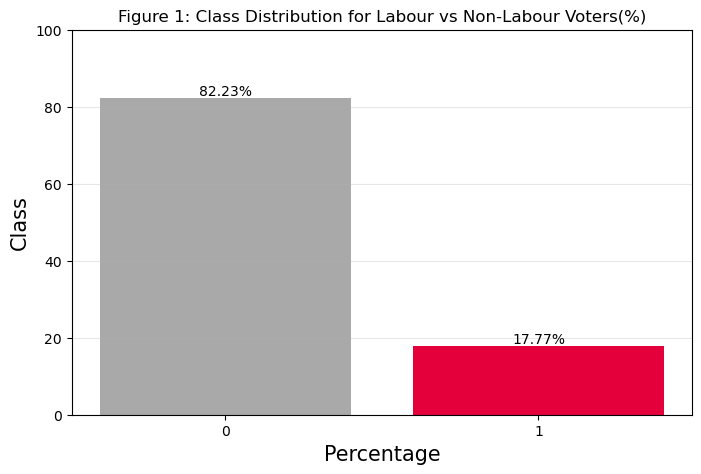

In [ ]:
#Create figure to display class imbalance as a barplot with percentages
import matplotlib.pyplot as plt

#Calculate class percentages
class_percentage = BES['Labour_vote'].value_counts(normalize = True).sort_index() * 100

#Make plot
plt.figure(figsize = (8, 5))
plt.bar(class_percentage.index.astype(str), class_percentage.values, color = ['darkgrey', '#E4003B'])

plt.title('Figure 1: Class Distribution for Labour vs Non-Labour Voters(%)')
plt.ylabel('Class', fontsize = 15)
plt.xlabel('Percentage', fontsize = 15)
plt.ylim(0, 100)
plt.grid(axis = 'y', alpha = 0.3)

#Add and format percentages
for i, pct in enumerate(class_percentage.values):
    plt.text(i, pct, f'{pct:.2f}%', ha = 'center', va = 'bottom')

plt.show()

In [ ]:
#Model 2 - Stratified

#Test/train split with stratification 
BES_train_stratified, BES_test_stratified = train_test_split(BES, test_size = 0.2, random_state = 42, stratify = BES[target])

#Checking classes are balanced
print(sum(BES_train_stratified[target])/len(BES_train_stratified[target]))
print(sum(BES_test_stratified[target])/len(BES_test_stratified[target]))

model2 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           eval_metric = 'logloss')

model2.fit(BES_train_stratified[features], BES_train_stratified[target])

pred2 = model2.predict(BES_test_stratified[features])

probability_model2 = model2.predict_proba(BES_test[features])[:,1]

metrics2 = {
    'Precision': precision_score(BES_test_stratified[target], pred2),
    'Recall': recall_score(BES_test_stratified[target], pred2),
    'F1': f1_score(BES_test_stratified[target], pred2),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model2)}

0.17768714209203643
0.1776239907727797


In [10]:
#Model 3 - Scale Weight

#Create scale weight
positive = sum(BES_train_stratified[target] == 0) 
negative = sum(BES_train_stratified[target] == 1)

print(positive/negative)

model3 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           scale_pos_weight = positive/negative,
                           eval_metric = 'logloss')

model3.fit(BES_train_stratified[features], BES_train_stratified[target])

pred3 = model3.predict(BES_test_stratified[features])

probability_model3 = model3.predict_proba(BES_test[features])[:,1]

metrics3 = {
    'Precision': precision_score(BES_test_stratified[target], pred3),
    'Recall': recall_score(BES_test_stratified[target], pred3),
    'F1': f1_score(BES_test_stratified[target], pred3),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model3)}

4.627869232552747


In [11]:
#Model 4 - Threshold

model4 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           scale_pos_weight = positive/negative,
                           eval_metric = 'logloss')

model4.fit(BES_train_stratified[features], BES_train_stratified[target])

probability_model4 = model4.predict_proba(BES_test_stratified[features])[:,1]

threshold = 0.15
pred4 = (probability_model4 >= threshold).astype(int)

metrics4 = {
    'Precision': precision_score(BES_test_stratified[target], pred4),
    'Recall': recall_score(BES_test_stratified[target], pred4),
    'F1': f1_score(BES_test_stratified[target], pred4),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model4)}

In [29]:
#Bayesian Optimisation - from Antigravity AI (Chat History - Appendix B)
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

# --- PREPARATION ---

# First, separate your features (X) and target variable (y) from your datasets
X_train = BES_train_stratified.drop('Labour_vote', axis=1) 
y_train = BES_train_stratified['Labour_vote']

X_test = BES_test_stratified.drop('Labour_vote', axis=1)
y_test = BES_test_stratified['Labour_vote']


# --- STEP 1: Set up the hyperopt search space ---

# Define the boundaries for the XGBClassifier hyperparameters you want to optimize
# - hp.quniform returns values rounded to the nearest given step (useful for integers)
# - hp.uniform returns continuous floats within the range
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),              # Depth of the tree (integers roughly 3 to 10)
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),      # Step size shrinkage (continuous 0.01 to 0.3)
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),     # Number of boosting rounds (trees)
    'subsample': hp.uniform('subsample', 0.5, 1.0),               # Fraction of observations to safely sample per tree
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0), # Fraction of columns to sample per tree
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),# Minimum instance weight needed in a child
    'gamma': hp.uniform('gamma', 0.0, 5.0)                        # Minimum loss reduction required for split
}


# --- STEP 2: Define objective function minimizing negative F1 score ---

def objective(params):
    # hyperopt passes parameters as floats by default if using uniform/quniform.
    # We must cast the hyperparameters that XGBoost expects to be integers.
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    # Initialize the XGBClassifier with the current set of parameters proposed by hyperopt
    clf = XGBClassifier(
        **params,
        enable_categorical=True,                                                                                                  #Added by me
        scale_pos_weight = positive/negative,                                                                                     #Added by me
        random_state=42,       # Ensures reproducibility
        eval_metric='logloss'  # Prevents unnecessary iteration warnings in newer XGBoost versions
    )
    
    # Train the model on the stratified training data
    clf.fit(X_train, y_train)
    
    # Predict on the stratified test data
    preds = clf.predict(X_test)
    
    # Calculate the positive F1 score (harmonic mean of precision and recall)
    f1 = f1_score(y_test, preds)
    
    # hyperopt is designed to strictly MINIMIZE the return value of the objective function.
    # Therefore, to maximize the F1 score, we return the negative F1 score. 
    # STATUS_OK tells hyperopt that the function executed successfully without errors.
    return {'loss': -f1, 'status': STATUS_OK}


# --- STEP 3: Run Bayesian optimization with 50 evaluations ---

# The Trials object will keep a record of all the hyperparameters and corresponding losses evaluated
trials = Trials()

# fmin is the main optimization function built into hyperopt
best = fmin(
    fn=objective,                    # The objective function we just defined above
    space=space,                     # The hyperparameter search space
    algo=tpe.suggest,                # The optimization algorithm (Tree-structured Parzen Estimator)
    max_evals=50,                    # The number of models/evaluations to test (50, as requested)
    trials=trials,                   # The history dictionary to record metrics
    rstate=np.random.default_rng(42) # Random state for consistent/reproducible optimization behavior
)

                                                                                                                                    #Convert necessary parameters to integer by me 
for key in best:
    if key in ['max_depth', 'min_child_weight', 'n_estimators']:
        best[key] = int(best[key])

# Output the best hyperparameters discovered
print("Best hyperparameters found during the Bayseian Search:", best)                                                              #Simplified to one print statement by me

100%|██████████| 50/50 [00:51<00:00,  1.02s/trial, best loss: -0.3645512999720436]
Best hyperparameters found during the Bayseian Search: {'colsample_bytree': np.float64(0.9397089388817566), 'gamma': np.float64(2.8701378921129685), 'learning_rate': np.float64(0.08176187698741404), 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 80, 'subsample': np.float64(0.8641506402202922)}


In [13]:
#Model 5 - Best Hyperparameters

model5 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           scale_pos_weight = positive/negative,
                           eval_metric = 'logloss',
                           **best)

model5.fit(BES_train_stratified[features], BES_train_stratified[target])

probability_model5 = model5.predict_proba(BES_test_stratified[features])[:,1]

threshold = 0.15
pred5 = (probability_model5 >= threshold).astype(int)

metrics5 = {
    'Precision': precision_score(BES_test_stratified[target], pred5),
    'Recall': recall_score(BES_test_stratified[target], pred5),
    'F1': f1_score(BES_test_stratified[target], pred5),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model5)}

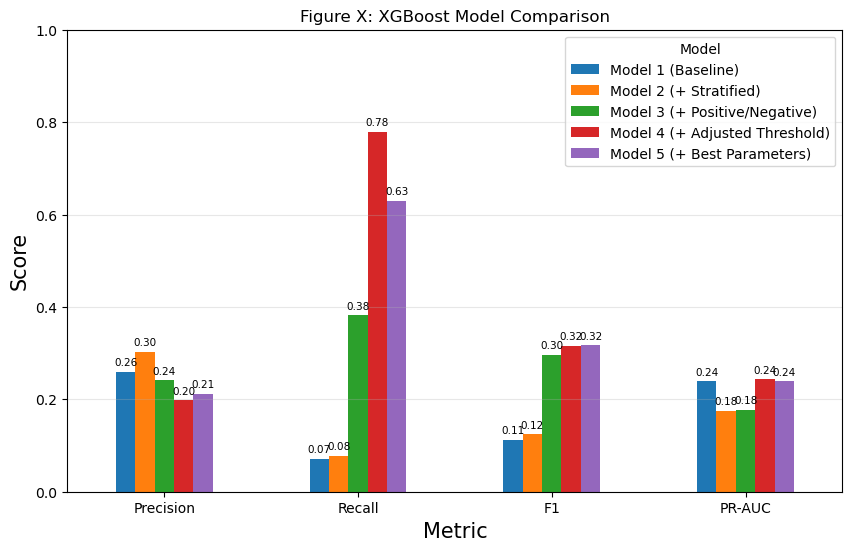

In [14]:
#Plot metrics

xgboost_model_scores = pd.DataFrame({
    'Model 1 (Baseline)': metrics1,
    'Model 2 (+ Stratified)': metrics2,
    'Model 3 (+ Positive/Negative)': metrics3,
    'Model 4 (+ Adjusted Threshold)': metrics4,
    "Model 5 (+ Best Parameters)": metrics5})

ax = xgboost_model_scores.plot(kind = 'bar', figsize = (10, 6))

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f', padding = 3, fontsize = 7.5)

plt.title('Figure X: XGBoost Model Comparison')
plt.ylabel('Score', fontsize = 15)
plt.xlabel('Metric', fontsize = 15)
plt.ylim(0, 1)
plt.xticks(rotation = 0)
plt.legend(title = 'Model')
plt.grid(axis = 'y', alpha = 0.3)
plt.show()

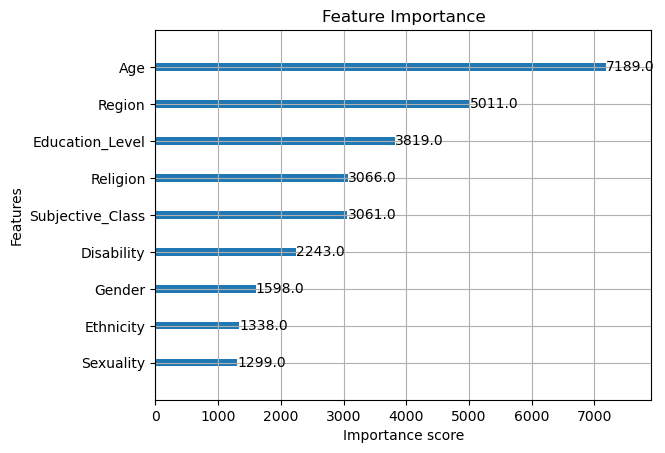

In [37]:
#Plot feature importance for model 5
import matplotlib.pyplot as plt

xgb.plot_importance(model5, importance_type = 'weight')
plt.title('Feature Importance')
plt.show()

#### **Random Forest**

In [16]:
#One-hot encode train and test sets
BES_train = BES_train.drop('General_Election_Vote', axis = 1)
BES_test = BES_test.drop('General_Election_Vote', axis = 1)

categorical_variables = ['Age', 'Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 
                         'Education_Level', 'Subjective_Class', 'Region']

BES_train = pd.get_dummies(BES_train, columns = categorical_variables) 
BES_test = pd.get_dummies(BES_test, columns = categorical_variables)

BES_test = BES_test.reindex(columns = BES_train.columns)
features = BES_train.columns.drop([target, 'id'])

In [17]:
#Model 1 - Baseline
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)

rf1.fit(BES_train[features], BES_train[target])

rf_pred1 = rf1.predict(BES_test[features])

rf1_probability = rf1.predict_proba(BES_test[features])[:,1]

rf_metrics1 = {
    'Precision': precision_score(BES_test[target], rf_pred1),
    'Recall': recall_score(BES_test[target], rf_pred1),
    'F1': f1_score(BES_test[target], rf_pred1),
    'PR-AUC': average_precision_score(BES_test[target], rf1_probability)}

In [18]:
#Model 2 - Stratified
BES_train_stratified = BES_train_stratified.drop('General_Election_Vote', axis = 1)
BES_test_stratified = BES_test_stratified.drop('General_Election_Vote', axis = 1)

categorical_variables = ['Age', 'Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 
                         'Education_Level', 'Subjective_Class', 'Region']

BES_train_stratified = pd.get_dummies(BES_train_stratified, columns = categorical_variables) 
BES_test_stratified = pd.get_dummies(BES_test_stratified, columns = categorical_variables)

BES_test_stratified = BES_test_stratified.reindex(columns = BES_train_stratified.columns)
features = BES_train_stratified.columns.drop([target, 'id'])

rf2 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)

rf2.fit(BES_train_stratified[features], BES_train_stratified[target])

rf_pred2 = rf2.predict(BES_test_stratified[features])

rf2_probability = rf2.predict_proba(BES_test_stratified[features])[:,1]

rf_metrics2 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred2),
    'Recall': recall_score(BES_test_stratified[target], rf_pred2),
    'F1': f1_score(BES_test_stratified[target], rf_pred2),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf2_probability)}

In [19]:
#Model 3 - Weights
rf3 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced', random_state = 42)

rf3.fit(BES_train_stratified[features], BES_train_stratified[target])

rf_pred3 = rf3.predict(BES_test_stratified[features])

rf3_probability = rf3.predict_proba(BES_test_stratified[features])[:,1]

rf_metrics3 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred3),
    'Recall': recall_score(BES_test_stratified[target], rf_pred3),
    'F1': f1_score(BES_test_stratified[target], rf_pred3),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf3_probability)}

In [20]:
#Model 4 - Adjusted Probaility Threshold
rf4 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced', random_state = 42)

rf4.fit(BES_train_stratified[features], BES_train_stratified[target])

rf4_probability = rf4.predict_proba(BES_test_stratified[features])[:, 1]

threshold = 0.15
rf_pred4 = (rf4_probability > threshold).astype(int)

rf_metrics4 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred4),
    'Recall': recall_score(BES_test_stratified[target], rf_pred4),
    'F1': f1_score(BES_test_stratified[target], rf_pred4),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf4_probability)}

In [21]:
#Hyperparameter Optimisation
from sklearn.model_selection import RandomizedSearchCV

parameter_distributions = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']}

rf = RandomForestClassifier(class_weight= 'balanced', random_state = 42)

random_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = parameter_distributions,
    n_iter = 5,
    scoring = 'f1',
    cv = 5,
    return_train_score = True,
    n_jobs = -1,
    verbose = 2,
    random_state = 42)

random_search.fit(BES_train_stratified[features], BES_train_stratified[target])

best_rf = random_search.best_estimator_

rf_probability = best_rf.predict_proba(BES_test_stratified[features])[:, 1]

threshold = 0.15
rf_prob = (rf_probability > threshold).astype(int)

print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'entropy'}


In [22]:
#Model 5 - Best Hyperparamters
rf5 = RandomForestClassifier(n_estimators = 200, 
                             max_features = 'log2',
                             max_depth = 15,
                             min_samples_split = 5,
                             min_samples_leaf = 4,
                             criterion = 'entropy', 
                             class_weight = 'balanced', 
                             random_state = 42)

rf5.fit(BES_train_stratified[features], BES_train_stratified[target])

rf5_probability = rf5.predict_proba(BES_test_stratified[features])[:, 1]

threshold = 0.15
rf_pred5 = (rf5_probability > threshold).astype(int)

rf_metrics5 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred5),
    'Recall': recall_score(BES_test_stratified[target], rf_pred5),
    'F1': f1_score(BES_test_stratified[target], rf_pred5),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf5_probability)}

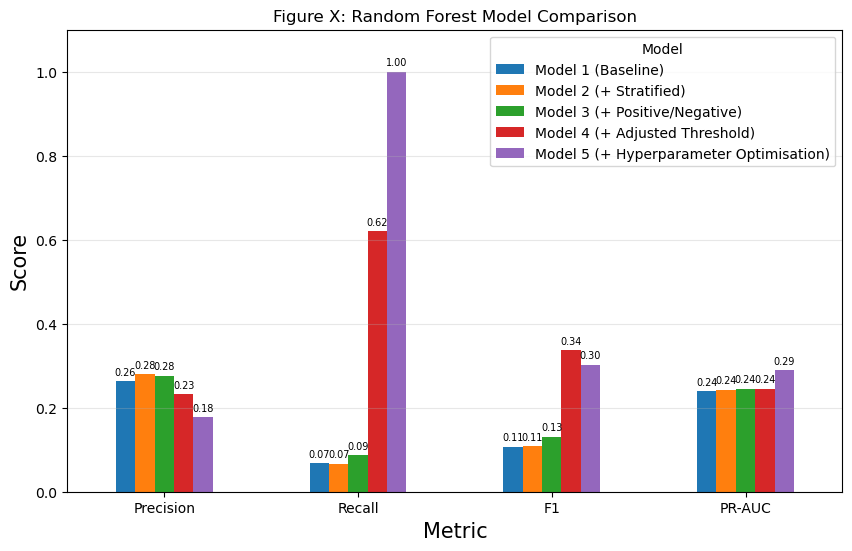

In [23]:
#Plot metrics
random_forest_scores = pd.DataFrame({
    'Model 1 (Baseline)': rf_metrics1,
    'Model 2 (+ Stratified)': rf_metrics2,
    'Model 3 (+ Positive/Negative)': rf_metrics3,
    'Model 4 (+ Adjusted Threshold)': rf_metrics4,
    'Model 5 (+ Hyperparameter Optimisation)': rf_metrics5})

ax = random_forest_scores.plot(kind = 'bar', figsize = (10, 6))

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f', padding = 3, fontsize = 7)

plt.title('Figure X: Random Forest Model Comparison')
plt.ylabel('Score', fontsize = 15)
plt.xlabel('Metric', fontsize = 15)
plt.ylim(0, 1.1)
plt.xticks(rotation = 0)
plt.legend(title = 'Model')
plt.grid(axis = 'y', alpha = 0.3)
plt.show()

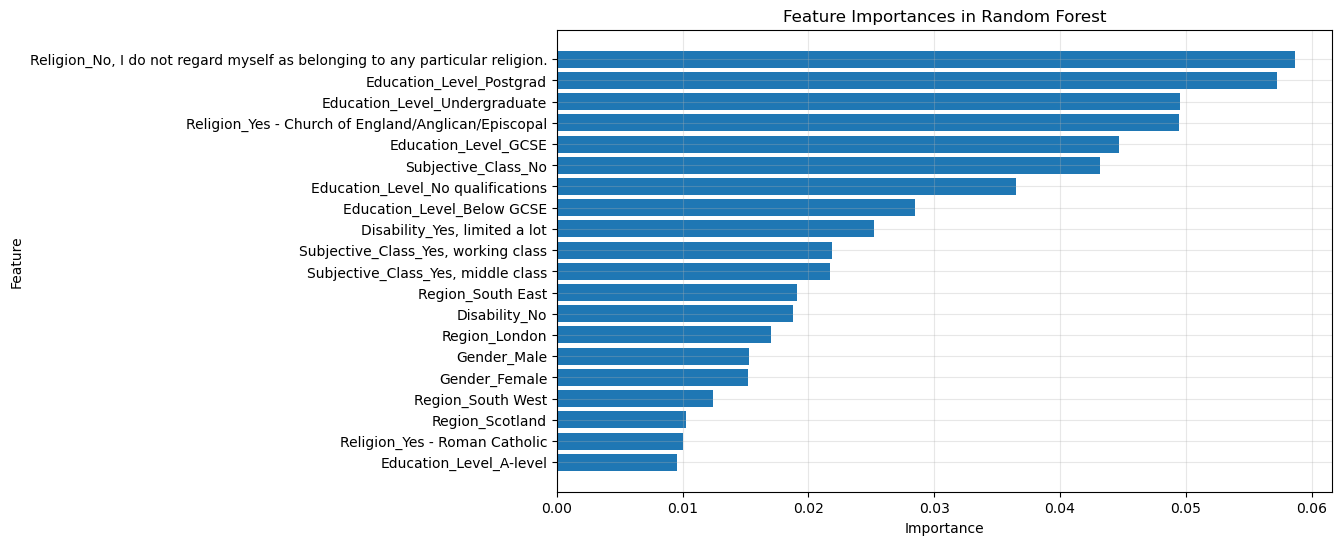

In [24]:
#Feature importance for model 5
importances = rf5.feature_importances_

sorted_idx = np.argsort(importances)[::-1]
top_idx = sorted_idx[:20]
sorted_features = [features[i] for i in top_idx]
sorted_importances = importances[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest')
plt.grid(alpha = 0.3)
plt.gca().invert_yaxis()
plt.show()

#### **Comparison**

In [25]:
#K-Fold Cross Validation for XGBoost
from sklearn.model_selection import cross_val_score

xgb_val = model5

xgb_precision = cross_val_score(xgb_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'precision') 

xgb_recall = cross_val_score(xgb_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'recall')

xgb_f1 = cross_val_score(xgb_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'f1')

xgb_prauc = cross_val_score(xgb_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'average_precision')

xgb_cv_metrics = pd.DataFrame({
    'Precision': [xgb_precision.mean()],
    'Recall': [xgb_recall.mean()],
    'F1': [xgb_f1.mean()],
    'PR-AUC': [xgb_prauc.mean()]})

In [26]:
#K-Fold Cross Validation for Random Forest
rf_val = rf5

rf_precision = cross_val_score(rf_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'precision') 

rf_recall = cross_val_score(rf_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'recall')

rf_f1 = cross_val_score(rf_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'f1')

rf_prauc = cross_val_score(rf_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'average_precision')

rf_cv_metrics = pd.DataFrame({
    'Precision': [rf_precision.mean()],
    'Recall': [rf_recall.mean()],
    'F1': [rf_f1.mean()],
    'PR-AUC': [rf_prauc.mean()]})

In [27]:
#Comparison Table
cv_results = pd.DataFrame({
    'Model': ['XGBoost Model 5', 'Random Forest Model 5'],
    'Precision': [xgb_cv_metrics['Precision'].iloc[0], rf_cv_metrics['Precision'].iloc[0]],
    'Recall': [xgb_cv_metrics['Recall'].iloc[0], rf_cv_metrics['Recall'].iloc[0]],
    'F1': [xgb_cv_metrics['F1'].iloc[0], rf_cv_metrics['F1'].iloc[0]],
    'PR-AUC': [xgb_cv_metrics['PR-AUC'].iloc[0], rf_cv_metrics['PR-AUC'].iloc[0]]
    })

cv_results[['Precision', 'Recall', 'F1', 'PR-AUC']] = cv_results[['Precision', 'Recall', 'F1', 'PR-AUC']].round(3)

display(cv_results)

,Model,Precision,Recall,F1,PR-AUC
0,XGBoost Model 5,0.252,0.480,0.330,0.254
1,Random Forest Model 5,0.265,0.575,0.363,0.285


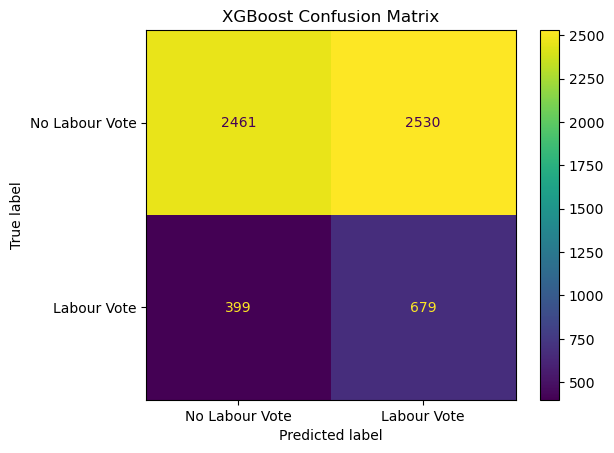

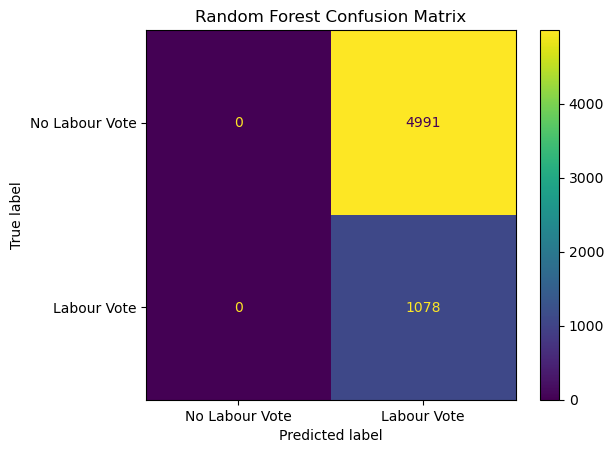

In [28]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(BES_test_stratified[target], pred5, display_labels = ['No Labour Vote', 'Labour Vote'])
plt.title('XGBoost Confusion Matrix')
plt.show()

ConfusionMatrixDisplay.from_predictions(BES_test_stratified[target], rf_pred5, display_labels = ['No Labour Vote', 'Labour Vote'])
plt.title('Random Forest Confusion Matrix')
plt.show()

### **Conclusion**

### **References**

### **Appendices**

#### **Appendix A - Github Repository Link**

#### **Appendix B - Google Antigravity AI Agent Chat History**

# Chat Conversation

Note: _This is purely the output of the chat conversation and does not contain any raw data, codebase snippets, etc. used to generate the output._

### User Input

I have British Election study wave data loaded in a pandas dataframe called BES.
The target variable is 'Labour_vote' (0 or 1) and all the other columns are binary features (0/1). 
I have already split the data into training (80%) and testing (20%), and stratified this to overcome class imbalance, the training and test datasets are called BES_training_stratified and BES_testing_stratified, respectively.

Please help me:
1. Set up a hyperopt search space for XGBclassifier hyperparamters (max_depth, learning_rate, n_estimators, subsample, colsample_bytree, min_child_weight, and gamma).
2. Define a objective function that minimises negative F1 score.
3. Run Bayesian optimisation with 50 evaluations.
4. Add comments explaining each step.

Provide the code so I can copy and paste it into my notebook. 

### Planner Response

Here is the complete code to set up and run the Bayesian optimization for your XGBoost model using `hyperopt`. I have structured it sequentially so you can copy and paste it directly into your Jupyter Notebook.

```python
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

# --- PREPARATION ---

# First, separate your features (X) and target variable (y) from your datasets
X_train = BES_training_stratified.drop('Labour_vote', axis=1)
y_train = BES_training_stratified['Labour_vote']

X_test = BES_testing_stratified.drop('Labour_vote', axis=1)
y_test = BES_testing_stratified['Labour_vote']


# --- STEP 1: Set up the hyperopt search space ---

# Define the boundaries for the XGBClassifier hyperparameters you want to optimize
# - hp.quniform returns values rounded to the nearest given step (useful for integers)
# - hp.uniform returns continuous floats within the range
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),              # Depth of the tree (integers roughly 3 to 10)
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),      # Step size shrinkage (continuous 0.01 to 0.3)
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),     # Number of boosting rounds (trees)
    'subsample': hp.uniform('subsample', 0.5, 1.0),               # Fraction of observations to safely sample per tree
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0), # Fraction of columns to sample per tree
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),# Minimum instance weight needed in a child
    'gamma': hp.uniform('gamma', 0.0, 5.0)                        # Minimum loss reduction required for split
}


# --- STEP 2: Define objective function minimizing negative F1 score ---

def objective(params):
    # hyperopt passes parameters as floats by default if using uniform/quniform.
    # We must cast the hyperparameters that XGBoost expects to be integers.
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    # Initialize the XGBClassifier with the current set of parameters proposed by hyperopt
    clf = XGBClassifier(
        **params,
        random_state=42,       # Ensures reproducibility
        eval_metric='logloss'  # Prevents unnecessary iteration warnings in newer XGBoost versions
    )
    
    # Train the model on the stratified training data
    clf.fit(X_train, y_train)
    
    # Predict on the stratified test data
    preds = clf.predict(X_test)
    
    # Calculate the positive F1 score (harmonic mean of precision and recall)
    f1 = f1_score(y_test, preds)
    
    # hyperopt is designed to strictly MINIMIZE the return value of the objective function.
    # Therefore, to maximize the F1 score, we return the negative F1 score. 
    # STATUS_OK tells hyperopt that the function executed successfully without errors.
    return {'loss': -f1, 'status': STATUS_OK}


# --- STEP 3: Run Bayesian optimization with 50 evaluations ---

# The Trials object will keep a record of all the hyperparameters and corresponding losses evaluated
trials = Trials()

# fmin is the main optimization function built into hyperopt
best = fmin(
    fn=objective,                    # The objective function we just defined above
    space=space,                     # The hyperparameter search space
    algo=tpe.suggest,                # The optimization algorithm (Tree-structured Parzen Estimator)
    max_evals=50,                    # The number of models/evaluations to test (50, as requested)
    trials=trials,                   # The history dictionary to record metrics
    rstate=np.random.default_rng(42) # Random state for consistent/reproducible optimization behavior
)

# Output the best hyperparameters discovered
print("Best hyperparameters found during the Bayseian Search:")
print(best)
```

### A Brief Note on the Final Output
When you print the `best` dictionary at the end, remember that hyperopt returns exact float values for all `quniform` searches. If you decide to train a final, permanent model on these best parameters, remember to cast the integers where necessary, for example: `max_depth = int(best['max_depth'])`.